# **Deduplication**

Deduplication of SIVEP-GRIPE stored in the warehouse.<br> 
The deduplication process is performed in order to generate data to train the final machine learning model to
identify a same individual for different records. 

There is no need to perform this task frequently, since there is no reason for domain shift. 

# **Lib**

In [1]:
import os
import sys
sys.path.append( os.path.dirname(os.path.abspath('')) )

In [2]:
import json
import glob
import shutil
import zipfile
import numpy as np
import pandas as pd
import datetime as dt
from simpledbf import Dbf5

import matplotlib.pyplot as plt

PyTables is not installed. No support for HDF output.


In [3]:
from epimonitor import WarehouseSUS
from epimonitor.process_layer import ProcessSivep, ProcessDB
from epimonitor.data_matching import Deduple

In [4]:
from sqlalchemy import create_engine, MetaData

# **Database Connection**

In [5]:
datapath = os.path.join(os.environ["HOMEPATH"], "Documents", "data")
dbpath = os.path.join(datapath, "DATASUS_WAREHOUSE", "datasus_pessoas.db") # it shouldn't be here in this script
engine_url = f"sqlite:///{dbpath}"

ex = create_engine(engine_url)

warehouse = WarehouseSUS(engine_url)
engine = warehouse.db_init()

In [19]:
nrecords = warehouse.number_of_records('sivep_gripe_label')
print(f"Total of records stored: {nrecords}")

Total of records stored: 0


# **Deduplication**

Between 2020 and 2023, sample **70%** of the data.

In [7]:
period = (dt.datetime(2020, 1, 1), dt.datetime.today())
query_data = pd.DataFrame( warehouse.query_period(table_name='sivep_gripe_pessoa', date_col="DATA_NOTIFICACAO", period=period) ).sample(frac=0.30)

KeyError: 'DATA_NOTIFICACAO'

In [8]:
print(query_data.info())
query_data.sample(n=4)

<class 'pandas.core.frame.DataFrame'>
Index: 29848 entries, 96914 to 69219
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID_SIVEP              29848 non-null  object        
 1   DATA_NOTIFICACAO      29848 non-null  datetime64[ns]
 2   NOME_PACIENTE         29848 non-null  object        
 3   DATA_NASCIMENTO       29825 non-null  datetime64[ns]
 4   SEXO                  29848 non-null  object        
 5   NOME_MAE              29015 non-null  object        
 6   LOGRADOURO            29122 non-null  object        
 7   LOGRADOURO_NUMERO     27674 non-null  object        
 8   BAIRRO_RESIDENCIA     28196 non-null  object        
 9   MUNICIPIO_RESIDENCIA  29848 non-null  object        
 10  CEP                   17788 non-null  object        
 11  CNS                   7444 non-null   object        
 12  CPF                   16015 non-null  object        
 13  CRIADO_EM        

,ID_SIVEP,DATA_NOTIFICACAO,NOME_PACIENTE,DATA_NASCIMENTO,SEXO,NOME_MAE,LOGRADOURO,LOGRADOURO_NUMERO,BAIRRO_RESIDENCIA,MUNICIPIO_RESIDENCIA,CEP,CNS,CPF,CRIADO_EM,ATUALIZADO_EM
99178,31692469895007,2023-08-19,REBECA SILVA LIMA,2018-10-21,F,REGINA LIMA SILVA,DIADEMA,365,DIADEMA,230523,None,708908702717915,None,2023-09-22 17:53:51.924146,2023-09-22 17:53:51.924146
39162,316239552057,2021-03-18,EDNARDO LIMA BARATA,1971-09-25,M,TEREZINHA LIMA BARATA,RUA NESTOR BARBOSA,315,AMADEU FURTADO,230440,None,None,None,2023-09-22 17:53:08.835376,2023-09-22 17:53:08.835376
31621,316132399976,2021-02-13,FRANCISCO GOMES DE ARAUJO,1943-05-10,M,MARIA GOMES DE ARAUJO,TENENTE ROMA,445,ALTO DA BALANCA,230440,60851030,None,24810479315,2023-09-22 17:53:05.835592,2023-09-22 17:53:05.835592
14667,315922264188,2020-06-15,FRANCISCO DANILO DE SOUSA,1954-07-25,M,INEZ MARIA DE JESUS,RUA 2-RESIDENCIAL BOA VISTA,93,AUTRAN NUNES,230440,None,None,16673140330,2023-09-22 17:52:45.079473,2023-09-22 17:52:45.079473


## **Process Sivep**

In [9]:
processor = ProcessDB(query_data, 'ID_SIVEP')

In [10]:
processor.basic_standardize().specific_standardize(field_id="ID_SIVEP")

In [11]:
processed_data = processor.data.copy()
processed_data.sample(n=4)

,ID_SIVEP,NOME_PACIENTE,NOME_MAE,DATA_NASCIMENTO,primeiro_nome,complemento_nome,primeiro_nome_mae,complemento_nome_mae,nascimento_dia,nascimento_mes,...,FONETICA_N,norm_primeiro_nome,rank_primeiro_nome,norm_primeiro_nome_mae,rank_primeiro_nome_mae,sexo,cpf,cns,bairro,cep
26105,316298093428,RONYELL FERNANDO BARBOSA,ANA VITORIA BARBOSA DA SILVA,2019-09-30,RONYELL,FERNANDO BARBOSA,ANA,VITORIA BARBOSA DA SILVA,30.0,9.0,...,RONYELLBARBOSA,0.000067,3,0.026568,6,M,11042361339,NaN,EDSON QUEIROZ,NaN
20627,316197085920,THIAGO OLIVEIRA SOUSA,NADJA OLIVEIRA SOUSA,1991-03-20,THIAGO,OLIVEIRA SOUSA,NADJA,OLIVEIRA SOUSA,20.0,3.0,...,THIAGOSOUSA,0.001675,4,0.000067,3,M,04518025350,NaN,PEDRAS,NaN
7478,31683345206426,BEATRIZ KEMILLY SANTOS SILVA,KATIANA DA SILVA OLIVEIRA,2023-01-03,BEATRIZ,KEMILLY SANTOS SILVA,KATIANA,DA SILVA OLIVEIRA,3.0,1.0,...,BEATRIZSILVA,0.000704,4,0.000168,3,F,None,NaN,PREFEITO JOSE WALTER,NaN
8183,31642426176146,ADILIO FARIAS DE ARAUJO,FRANCISCA HIGINO FARIAS DE ARAUJO,1983-08-17,ADILIO,FARIAS DE ARAUJO,FRANCISCA,HIGINO FARIAS DE ARAUJO,17.0,8.0,...,ADILIOARAUJO,0.000034,2,0.075750,6,M,01440909377,NaN,MARECHAL RONDON,NaN


**TOP 10 names**

In [12]:
processor.freq_names[pd.isna(processor.freq_names["rank_primeiro_nome_mae"])]

,primeiro_nome,norm_primeiro_nome,rank_primeiro_nome,primeiro_nome_mae,norm_primeiro_nome_mae,rank_primeiro_nome_mae


## **Deduple**

In [13]:
#dedupe_path = os.path.join(datapath, "SIVEP-GRIPE", "TRAINING_DATA_CLASSIFIER", "DEDUPE_FILES")
deduple = Deduple(processed_data, left_id="ID_SIVEP", env_folder=None)

linkage_vars = [
    ("cpf", "cpf", "exact", 'cpf'),
    ("cns", "cns", "exact", 'cns'),
    ("cep", "cep", "exact", 'cep'),
    ("sexo", "sexo", "exact", 'sexo'),
    ("nascimento_dia", "nascimento_dia", "exact", 'nascimento_dia'),
    ("nascimento_mes", "nascimento_mes", "exact", 'nascimento_mes'),
    ("nascimento_ano", "nascimento_ano", "exact", 'nascimento_ano'),
    ("primeiro_nome", "primeiro_nome", "string", 'primeiro_nome'),
    ("primeiro_nome_mae", "primeiro_nome_mae", "string", 'primeiro_nome_mae'),
    ("complemento_nome", "complemento_nome", "string", 'complemento_nome'),
    ("complemento_nome_mae", "complemento_nome_mae", "string", 'complemento_nome_mae'),
]

deduple.set_linkage_variables(linkage_vars, string_method="damerau_levenshtein").define_pairs('FONETICA_N', window=3)

Number of pairs: 621290


In [14]:
deduple.perform_linkage(threshold=0.60, number_of_blocks=4)

Matching subset batch 1/4 of size 155323 ...
Matching subset batch 2/4 of size 155323 ...
Matching subset batch 3/4 of size 155322 ...
Matching subset batch 4/4 of size 155322 ...
Done.


In [15]:
deduple.comparison_matrix.sample(n=5)

,,cpf,cns,cep,sexo,nascimento_dia,nascimento_mes,nascimento_ano,primeiro_nome,primeiro_nome_mae,complemento_nome,complemento_nome_mae,rank_primeiro_nome,rank_primeiro_nome_mae
ID_SIVEP_1,ID_SIVEP_2,,,,,,,,,,,,,
316262809774,31660565385996,0,0,0,1,0,0,0,1.0,1.0,0.0,0.0,7,7
316264549534,31646860054605,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,6,6
316111661030,31685430653005,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,7,6
315888747637,316376057600,0,0,0,1,0,0,0,1.0,1.0,0.0,0.0,7,6
316183245529,316382147210,0,0,0,1,1,0,0,1.0,1.0,1.0,0.0,6,7


In [ ]:
#deduple.comparison_matrix.to_parquet(os.path.join(dedupe_path, "feature_pairs.parquet"))

## **Define easy, intermediate and hard similarity cases**

Based on the individual similarity values, create a rule-based aggregated value $S'$ to identify the easy cases.

Considering a given pair $(k,l)$ of records, the sum $S$ for $(k,l)$ is defined as $ S(k,l) = \sum_i x^i(k,l) $, where $\vec{x}(k,l) = \big\langle x^1(k,l), ..., x^n(k,l) \big\rangle$ and $x^i$ is the ith comparison feature of the similarity matrix. Also, before defining $S'$, we consider the two following sums:
$$
S_{\text{nasc}} = x^{\text{birth-day}} + x^{\text{birth-month}} + x^{\text{birth-year}},
$$
$$
S_{\text{nome}} = x^{\text{first-name}} + x^{\text{complement-name}} + x^{\text{sexo}},
$$ and
$$
S_{\text{nome_mae}} = x^{\text{first-name-mother}} +  x^{\text{complement-name-mother}}
$$

In [18]:
aggregated_similarity = pd.DataFrame()
comparison_matrix = deduple.comparison_matrix

map_sum = {
    "S": list(map_compare.keys()),
    "S_NASC": ["nascimento_dia", "nascimento_mes", "nascimento_ano"],
    "S_NOME": ["primeiro_nome", "complemento_nome"],
    "S_NOME_MAE": ["primeiro_nome_mae", "complemento_nome_mae"],
    "S_CPF": ["cpf"],
}
for key, value in map_sum.items(): aggregated_similarity[key] = comparison_matrix[value].apply(sum, axis=1)
aggregated_similarity = aggregated_similarity.merge(comparison_matrix[["rank_primeiro_nome", "rank_primeiro_nome_mae"]], left_index=True, right_index=True, how="left")

In [21]:
aggregated_similarity.sort_values(by="S", ascending=False)

,,S,S_NASC,S_NOME,S_NOME_MAE,S_CPF,rank_primeiro_nome,rank_primeiro_nome_mae
ID_SIVEP_1,ID_SIVEP_2,,,,,,,
316294634646,316275584449,12.0,3,2.0,2.0,1,4,7
316174938257,31647362880449,12.0,3,2.0,2.0,1,7,7
31644422466867,31643894368143,12.0,3,2.0,2.0,1,6,7
316420131858,31643055410225,12.0,3,2.0,2.0,1,4,3
316412238104,316412236869,12.0,3,2.0,2.0,1,7,7
...,...,...,...,...,...,...,...,...
31643047287865,315881772359,0.0,0,0.0,0.0,0,2,5
316151651772,316229157680,0.0,0,0.0,0.0,0,2,4
316167556407,316194453966,0.0,0,0.0,0.0,0,3,5


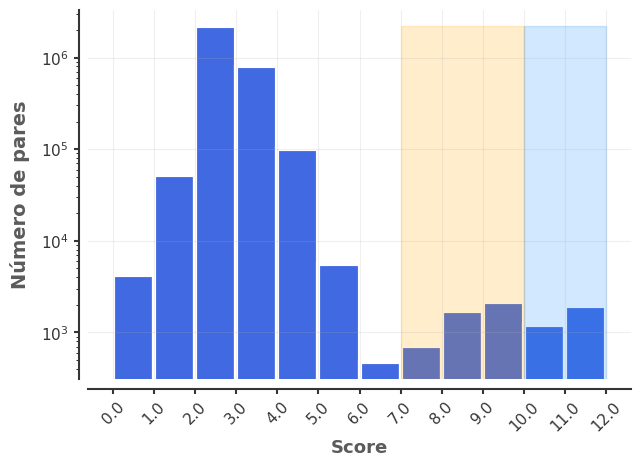

In [20]:
# -- visualize score distribution
bins1 = np.arange(0, 13.0, 1.0) 
res1 = deduple.score_summary(aggregated_similarity["S"], bins1, [10,12], [7,10], scale="log")

## **Create annotation files**

In [118]:
sf = aggregated_similarity["S"]

high_pairs = list(comparison_matrix[(sf>=10)].index)
midhigh_pairs = list(comparison_matrix[(sf>=8.0) & (sf<=10)].index)
mid_pairs = list(comparison_matrix[(sf>=7.0) & (sf<8.0)].index)
midlow_pairs = list(comparison_matrix[(sf>=5.0) & (sf<7.0)].sample(n=5000).index)
low_pairs = list(comparison_matrix[(sf>=0.0) & (sf<=5.0)].sample(n=5000).index)

list_of_pairs = high_pairs + midhigh_pairs + mid_pairs + midlow_pairs + low_pairs 

In [119]:
print(len(high_pairs), len(midhigh_pairs), len(mid_pairs), len(midlow_pairs), len(low_pairs), len(list_of_pairs))

3129 5064 716 5000 5000 18909


In [26]:
#deduple.left_df["NASCIMENTO"] = deduple.left_df["DATA_NASCIMENTO"].apply(lambda x: f"{x.day:2.0f}/{x.month:2.0f}/{x.year}".replace(" ", "0") if pd.notna(x) else np.nan)

In [31]:
cols = ["NOME_PACIENTE", "NASCIMENTO", "NOME_MAE", 
        "bairro", "sexo", "cpf", "cns", "cep"]
vis = deduple.show_pair(midhigh_pairs, left_cols=cols, random_state=None)
print(f"SCORE: {sf.loc[(vis.columns[0], vis.columns[1])]}")
vis

SCORE: 10.0


,316415769409,31644498657813
NOME_PACIENTE,MARINA DOS SANTOS MORAIS,MARINA DOS SANTOS MORAIS
NASCIMENTO,13/01/1989,13/01/1989
NOME_MAE,AURILENE MONTEIRO DOS SANTOS,AURILENE MONTEIRO DOS SANTOS
bairro,BARRA,NaN
sexo,F,F
cpf,03532675382,03532675382
cns,NaN,NaN
cep,62815000,62815000


In [121]:
aggr_df = aggregated_similarity[["S", "S_NOME", "S_NASC", "S_NOME_MAE"]]

deduple_path_high = os.path.join(dedupe_path, "HIGH_PAIRS")
deduple_path_midhigh = os.path.join(dedupe_path, "MIDHIGH_PAIRS")
deduple_path_mid = os.path.join(dedupe_path, "MID_PAIRS")
deduple_path_midlow = os.path.join(dedupe_path, "MIDLOW_PAIRS")
deduple_path_low = os.path.join(dedupe_path, "LOW_PAIRS")

for folder in [deduple_path_high, deduple_path_midhigh, deduple_path_mid, deduple_path_midlow, deduple_path_low]:
    if not os.path.isdir(folder):
        os.mkdir(folder)

In [122]:
#deduple.save_files(high_pairs, aggr_df, output_folder=deduple_path_high, left_cols=cols, right_cols=cols, overwrite=True, batchsize=150)
#deduple.save_files(midhigh_pairs, aggr_df, output_folder=deduple_path_midhigh, left_cols=cols, right_cols=cols, overwrite=True, batchsize=150)
#deduple.save_files(mid_pairs, aggr_df, output_folder=deduple_path_mid, left_cols=cols, right_cols=cols, overwrite=True, batchsize=150)
#deduple.save_files(midlow_pairs, aggr_df, output_folder=deduple_path_midlow, left_cols=cols, right_cols=cols, overwrite=True, batchsize=150)
#deduple.save_files(low_pairs, aggr_df, output_folder=deduple_path_low, left_cols=cols, right_cols=cols, overwrite=True, batchsize=150)

In [36]:
# -- open classification files

In [689]:
sel_folder = deduple_path_high
pair_number = 5
with open(os.path.join(sel_folder, f"PAIRS_{pair_number}.json"), "r") as f:
    data = json.load(f)

In [690]:
freq_sum = {
    "S": [ data['pairs'][n]['agg']['S'] for n in range( len(data['pairs']) ) ],
    "S_NOME": [ data['pairs'][n]['agg']['S_NOME'] for n in range( len(data['pairs']) ) ],
    "S_NOME_MAE": [ data['pairs'][n]['agg']['S_NOME_MAE'] for n in range( len(data['pairs']) ) ],
    "S_NASC": [ data['pairs'][n]['agg']['S_NASC'] for n in range( len(data['pairs']) ) ]
}

Text(0, 0.5, 'Freq. Nascimento')

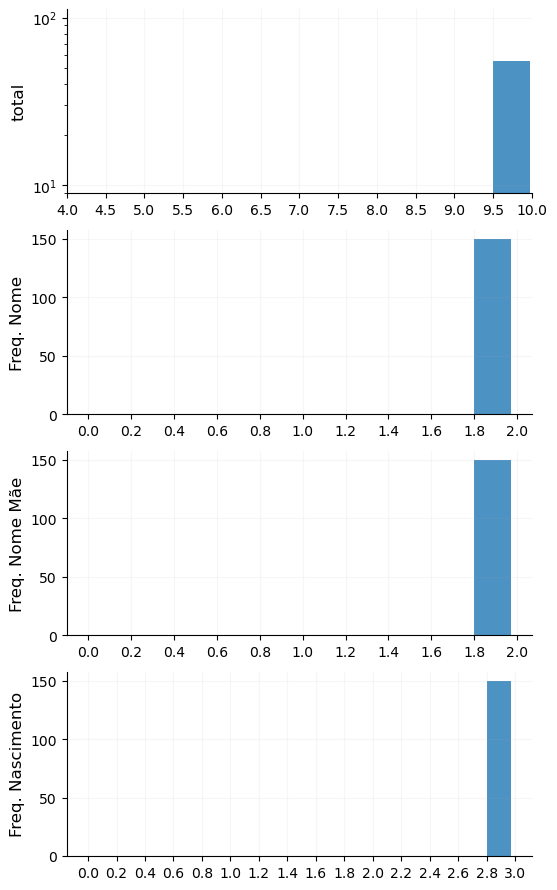

In [691]:
soma_arr = freq_sum["S"]
nome_arr = freq_sum["S_NOME"]
nomemae_arr = freq_sum["S_NOME_MAE"]
nasc_arr = freq_sum["S_NASC"]

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(6,11))
freq_soma, interval_soma = np.histogram(soma_arr, bins=np.arange(4, 10.2, 0.5))
freq_nome, interval_nome = np.histogram(nome_arr, bins=np.arange(0, 2.2, 0.2))
freq_nomemae, interval_nomemae = np.histogram(nomemae_arr, bins=np.arange(0, 2.2, 0.2))
freq_nasc, interval_nasc = np.histogram(nasc_arr, bins=np.arange(0, 3.2, 0.2))

ax0.bar(interval_soma[:-1], freq_soma, align='edge', width=0.47, color='tab:blue', alpha=0.8)
ax1.bar(interval_nome[:-1], freq_nome, align='edge', width=0.17, color='tab:blue', alpha=0.8)
ax2.bar(interval_nomemae[:-1], freq_nomemae, align='edge', width=0.17, color='tab:blue', alpha=0.8)
ax3.bar(interval_nasc[:-1], freq_nasc, align='edge', width=0.17, color='tab:blue', alpha=0.8)

for axis in [ax0, ax1, ax2, ax3]:
    axis.grid(alpha=0.1)
    axis.set_xticks(np.arange(0, 2.2, 0.2))
    #axis.set_xlabel("sum", fontsize=12)
    axis.set_ylabel("total", fontsize=12)
    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
ax3.set_xticks(np.arange(0, 3.2, 0.2))
ax0.set_xticks(np.arange(4, 10.2, 0.5))
ax0.set_xlim([4,10])
ax0.set_yscale('log')
ax1.set_ylabel("Freq. Nome")
ax2.set_ylabel("Freq. Nome Mãe")
ax3.set_ylabel("Freq. Nascimento")

In [688]:
nascl = [ (data['pairs'][n]['identifiers']['a'], data['pairs'][n]['identifiers']['b']) for n in range( len(data['pairs']) ) if data['pairs'][n]['agg']['S_NASC']>=1.0 and data['pairs'][n]['agg']['S_NASC']<=3.1 ]
nomel = [ (data['pairs'][n]['identifiers']['a'], data['pairs'][n]['identifiers']['b']) for n in range( len(data['pairs']) ) if data['pairs'][n]['agg']['S_NOME']>=1.1 and data['pairs'][n]['agg']['S_NOME']<=2.9 ]
nomemael = [ (data['pairs'][n]['identifiers']['a'], data['pairs'][n]['identifiers']['b']) for n in range( len(data['pairs']) ) if data['pairs'][n]['agg']['S_NOME_MAE']>=1.1 and data['pairs'][n]['agg']['S_NOME_MAE']<=2.9 ]

In [646]:
sset = set(nascl).intersection(set(nomel)).intersection( (set(nomemael)) )
lset = list(sset)
print(len(lset))
lset

34


[('316372566589', '316255759512'),
 ('315875047100', '316171920842'),
 ('316240248835', '316255790590'),
 ('316418507615', '316058684533'),
 ('316189247578', '316316242109'),
 ('31668794380466', '316053578202'),
 ('316194663973', '316179655416'),
 ('31642773965909', '315881648306'),
 ('31656236250447', '316339552433'),
 ('315924440654', '315886060067'),
 ('31659016283657', '316109912233'),
 ('316165015951', '316166960104'),
 ('315915499327', '315896595434'),
 ('31665868372828', '316250634499'),
 ('316034473812', '31659017880521'),
 ('31686508522557', '31677504394062'),
 ('31649863917030', '316073448456'),
 ('31642439731949', '316219625405'),
 ('31676338321199', '31642304337272'),
 ('316171300227', '316240400705'),
 ('316264670924', '316307572815'),
 ('31672430054622', '316325819708'),
 ('316177970757', '315895450865'),
 ('316239383536', '316224898751'),
 ('316158171865', '316200677921'),
 ('316310144880', '315955299518'),
 ('316148772608', '316039691143'),
 ('316143493672', '3159432553

In [680]:
iindex = 33
#lset = list(sset)
ex = [ data['pairs'][n] for n in range( len(data['pairs']) ) if data['pairs'][n]['identifiers']['a']==lset[iindex][0] and data['pairs'][n]['identifiers']['b']==lset[iindex][1] ]
ex

[{'cod': 730,
  'classification': 'negative',
  'a': {'NOME_PACIENTE': 'JOSE VALDIR PEREIRA DA SILVA',
   'NASCIMENTO': '08/09/1960',
   'NOME_MAE': 'MARIA PEREIRA DA SILVA',
   'bairro': 'PASSARE',
   'sexo': 'M',
   'cpf': None,
   'cns': nan,
   'cep': '60861790'},
  'b': {'NOME_PACIENTE': 'JOSE FERREIRA DA SILVA',
   'NASCIMENTO': '17/09/1939',
   'NOME_MAE': 'MARIA ROSA DA SILVA',
   'bairro': 'PASSARE',
   'sexo': 'M',
   'cpf': None,
   'cns': nan,
   'cep': nan},
  'identifiers': {'a': '316156526345', 'b': '316063321233'},
  'agg': {'S': 6.3396739130434785,
   'S_NOME': 1.6521739130434783,
   'S_NASC': 1,
   'S_NOME_MAE': 1.6875}}]

In [373]:
pd.DataFrame(ex[0]['a'], index=None)

ValueError: If using all scalar values, you must pass an index

In [301]:
ex[0]['a']

{'NOME_PACIENTE': 'FRANCISCO ALVES DA SILVA',
 'NASCIMENTO': '17/02/1971',
 'NOME_MAE': 'FRANCISCA ALVES DA SILVA',
 'bairro': 'CRUZEIRO',
 'sexo': 'M',
 'cpf': '45462372353',
 'cns': nan,
 'cep': '60000000'}

In [27]:
pd.MultiIndex.from_tuples([(1,2), (3,4), (5,6)]).shape[0]

3